Import

In [1]:

%load_ext autoreload
%autoreload 2

from model import Net
from dataloader import *
from dataloader_utils import *
from yolo_utils import *
from loss import *

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import torch
import sys
sys.argv.append("-Xfrozen_modules=off")

%matplotlib inline


Load data

In [2]:
dataloader = DataLoader()
dataloader.load_data(max_file=100, more_data=False)

Loading data...
Loading data done.
Train set size:  100
Test set size:  0


Show data

original image size: (370, 500, 3)
[{'xmin': 36, 'ymin': 250, 'xmax': 79, 'ymax': 354, 'cx': 0.115, 'cy': 0.8162162162162162, 'w': 0.086, 'h': 0.2810810810810811, 'width': 500, 'height': 370, 'class': 'bottle', 'confidence': 1}, {'xmin': 160, 'ymin': 26, 'xmax': 371, 'ymax': 241, 'cx': 0.531, 'cy': 0.3608108108108108, 'w': 0.422, 'h': 0.581081081081081, 'width': 500, 'height': 370, 'class': 'tvmonitor', 'confidence': 1}]


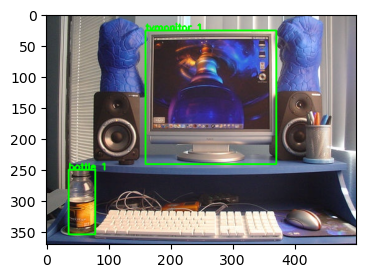

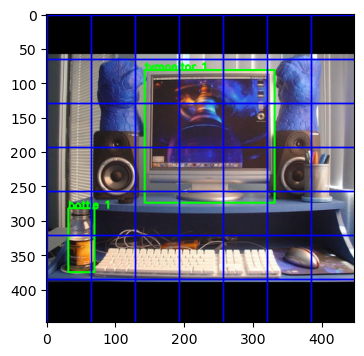

(448, 448, 3)
(1, 7, 7, 30)
[0.7109375  0.7734375  0.421875   0.43080357 1.         0.7109375
 0.7734375  0.421875   0.43080357 1.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[0.796875   0.1328125  0.08482143 0.20758928 1.         0.796875
 0.1328125  0.08482143 0.20758928 1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
[{'cx': 0.5301339285714286, 'cy': 0.39620535714285715, 'w': 0.421875, 'h': 0.43080357, 'class': 'tvmonitor', 'confidence': 1.0, 'width': 448, 'height': 448, 'xmin': 143, 'ymin': 81, 'xmax': 332, 'ymax': 273}, {'cx': 0.11383928571428571, 'cy': 0.7332589285714286, 'w': 0.084821425, 'h': 0.20758928, 'class': 'bottle', 'confidence': 1.0, 'width': 448, '

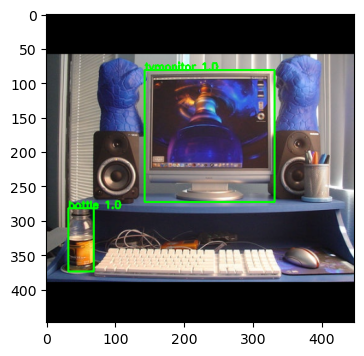

In [3]:
np.random.seed(42)

# randomly select an image
# idx = np.random.randint(len(dataloader.train_images))
# idx = max(0, min(idx, len(dataloader.train_images) - 1))
idx = 0
image = dataloader.train_images[idx]
original_image = image.copy()
original_boxes = dataloader.train_labels[idx]["boxes"]

# plot original image
print("original image size:", original_image.shape)
print(original_boxes)
original_image = plot_bbox_on_image(original_image, original_boxes)
plt.figure(figsize=(4, 4))
plt.imshow(original_image)

# plot the image
image = dataloader.train_labels[idx]["resized_image"]
boxes = dataloader.train_labels[idx]["resized_boxes"]
plot_image = image.copy()
plot_boxes = copy.deepcopy(boxes)
plot_images, plot_boxes = image_resize2sq(plot_image, plot_boxes)
plot_image = plot_bbox_on_image(plot_image, boxes)
plt.figure(figsize=(4, 4))
plt.imshow(plot_image)

# mark the grids of the image
grid_size = INPUT_SIDE / N_GRID_SIDE
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        rect = plt.Rectangle((i * grid_size, j * grid_size), grid_size, grid_size, fill=False, edgecolor="blue", linewidth=1)
        plt.gca().add_patch(rect)

plt.show()

# show the non-zero numbers of the label
image, label = dataloader.pull_item(idx)
label = label.reshape(1, N_GRID_SIDE, N_GRID_SIDE, 30)
print(image.shape)
print(label.shape)
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        if label[0, i, j, 4] != 0:
            print(label[0, i, j, :])

# label2boxes
label = label.reshape(N_GRID_SIDE, N_GRID_SIDE, 30)
pred_boxes = label2box(label)
print(pred_boxes)
pred_boxes = non_max_suppression(pred_boxes)
print(pred_boxes)

# plot the image
image = plot_bbox_on_image(image, pred_boxes)
plt.figure(figsize=(4, 4))
plt.imshow(image)


Test yolo utils

In [ ]:
batch_size = BATCH_SIZE
train_lab = [0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 1]
# Train labels are zeros, except for the first grid cell
train_label = np.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))
train_label[0, 0, 0, :10] = train_lab
train_label = torch.from_numpy(train_label).float()

train_forward = torch.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))

loss = yolo_loss_be(train_forward, train_label)
print(loss)
loss2 = yolo_loss_be(train_label, train_label)
print(loss2)



In [2]:
box1 = {"xmin": 1, "ymin": 1, "xmax": 3, "ymax": 3}
box2 = {"xmin": 2, "ymin": 2, "xmax": 4, "ymax": 4}
iou1 = iou(box1, box2)
giou1 = giou(box1, box2)
print(iou1)
print(giou1)
iou2 = iou(box1, box1)
giou2 = giou(box1, box1)
print(iou2)
print(giou2)

0.14285714285510204
-0.07936507936465104
0.999999999975
0.999999999975


Test model.

In [ ]:
train_images, train_labels = next(dataloader.get_train_batch())
net = Net(device="cpu")

# Test forward
train_images = torch.from_numpy(train_images).float()
train_labels = torch.from_numpy(train_labels).float()
train_images = train_images.permute(0, 3, 1, 2)
train_labels = train_labels.reshape(-1, N_GRID_SIDE, N_GRID_SIDE, 30)
forward = net.forward(train_images)
print("Forward shape: ", forward.shape)
print("Label shape: ", train_labels.shape)
 
loss = yolo_loss_be(forward, train_labels)
print(loss)


test Train

In [ ]:
train = Train()

Load Weight.

In [8]:
net = Net()
net.load_weights("weights220.pth")

Weights loaded.


In [17]:
from evaluate import *
from model import *
test_images = dataloader.test_images
test_boxes = [label["boxes"] for label in dataloader.test_labels]
pred_boxes = net.predict(test_images)
mAP, APs = compute_mAP(pred_boxes, test_boxes, print_pr=True)
print("mAP: ", mAP)
print("APs: ", APs)

Predicting


100%|██████████| 2/2 [00:31<00:00, 15.71s/it]


AP for class person: 0.4201
precision: 0.4846, recall: 0.6976
mAP:  0.42010288697699166
APs:  {'person': 0.42010288697699166}


compute map. visualize the result.

In [ ]:

# Test predict
import torch

# Visualize the prediction

# Test on train images
train_images = dataloader.train_images[:20]
train_boxes = [msg["boxes"] for msg in dataloader.train_msg[:20]]
train_labels = dataloader.train_labels[:20]
train_labels = torch.Tensor(train_labels).float()
train_labels = train_labels.reshape(-1, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES)
train_images = np.array(train_images)
original_train_images = train_images
pred_labels = net.forward(torch.Tensor(train_images).float().permute(0, 3, 1, 2))
boxes = net.predict(train_images)

# print pred label and gt label
# find where the label is not zero
print(yolo_loss(pred_labels, train_labels))




In [ ]:
idx = 6
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        if train_labels[idx][i, j, 4] > 0:
            print(train_labels[idx][i, j, :])
            print(pred_labels[idx][i, j, :])

plt.figure(figsize=(4, 4))
plt.imshow(original_train_images[idx])
for box in boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()
# plot ground truth
plt.figure(figsize=(4, 4))
plt.imshow(original_train_images[idx])
for box in train_boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")




In [ ]:
import sys
sys.argv.append("-Xfrozen_modules=off")

# Test images
test_images = dataloader.test_images
test_images = np.array(test_images)
original_test_images = test_images
print(test_images.shape)
test_boxes = [msg["boxes"] for msg in dataloader.test_msg]
mAP = net.evaluate(test_images, test_boxes)
test_images = test_images[0:32]
test_boxes = test_boxes[0:32]
boxes_ = net.predict(test_images)
print(mAP)


In [ ]:
idx = 16

plt.figure(figsize=(4, 4))
plt.imshow(original_test_images[idx])
for box in boxes_[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()

# plot ground truth
plt.figure(figsize=(4, 4))
plt.imshow(original_test_images[idx])
for box in test_boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()